C:\Users\eoin0\AppData\Local\Temp\ipykernel_15672\216172396.py:15: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  road_data = pd.read_csv('collision.csv')
C:\Users\eoin0\AppData\Local\Temp\ipykernel_15672\216172396.py:46: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  road_data['road_type'] = road_data['road_type'].replace(road_type_mapping).astype('category')
C:\Users\eoin0\AppData\Local\Temp\ipykernel_15672\216172396.py:206: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  road_data['time'] = pd.to_datetime(road_data['time'], errors='coerce').dt.strftime('%H:%M')  # Coerce invalid ti

Logistic Regression Accuracy: 0.8563549160671463
Logistic Regression Classification Report:
               precision    recall  f1-score   support

       Rural       0.90      0.63      0.74      6736
       Urban       0.84      0.97      0.90     14114

    accuracy                           0.86     20850
   macro avg       0.87      0.80      0.82     20850
weighted avg       0.86      0.86      0.85     20850



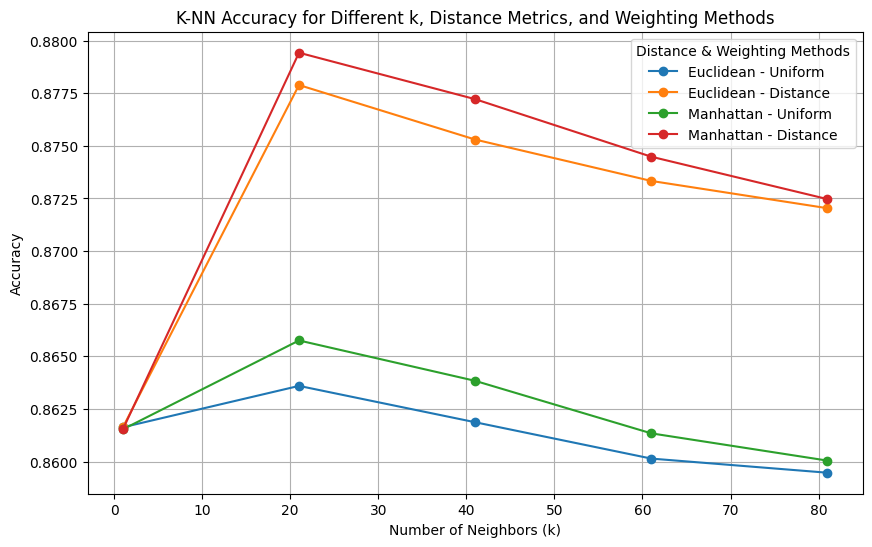

In [41]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
# Constants
UNKNOWN_SELF_REPORTED = "unknown (self reported)"
NOT_AT_JUNCTION = "Not at junction or within 20 metres"
DATA_MISSING_OR_OUT_OF_RANGE = "Data missing or out of range"
RANDOM_STATE_SEED = 42

# Load dataset
road_data = pd.read_csv('collision.csv')

# Fill missing values with the median
road_data[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']] = road_data[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].fillna(road_data[['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude']].median())

# Replace -1 with NaN for missing values
road_data["speed_limit"] = road_data["speed_limit"].replace(-1, pd.NA)

# Handle unknown values (e.g., 99)
road_data["speed_limit"] = road_data["speed_limit"].replace(99, pd.NA)

# Optionally drop rows with missing or unknown speed limits
road_data = road_data[road_data["speed_limit"].notna()]

# Replace invalid values (e.g., -1) with NaN
road_data['road_type'] = road_data['road_type'].replace(-1, pd.NA)

# Convert to category after cleanup
road_data['road_type'] = road_data['road_type'].astype('category')

# Adjust mapping logic based on actual data
road_type_mapping = {
    1: "Roundabout",
    2: "One way street",
    3: "Dual carriageway",
    6: "Single carriageway",
    7: "Slip road",
    12: "One way street/Slip road",
    -1: pd.NA,  # Data missing
    9: pd.NA    # Unknown
}
road_data['road_type'] = road_data['road_type'].replace(road_type_mapping).astype('category')

junction_detail_mapping = {
    0: NOT_AT_JUNCTION, 1: "Roundabout", 2: "Mini-roundabout",
    3: "T or staggered junction", 5: "Slip road", 6: "Crossroads", 7: "More than 4 arms (not roundabout)",
    8: "Private drive or entrance", 9: "Other junction", 99: UNKNOWN_SELF_REPORTED, -1: DATA_MISSING_OR_OUT_OF_RANGE
}

junction_control_mapping = {
    0: NOT_AT_JUNCTION, 1: "Authorised person", 2: "Auto traffic signal",
    3: "Stop sign", 4: "Give way or uncontrolled", -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

second_road_class_mapping = {
    0: NOT_AT_JUNCTION, 1: "Motorway", 2: "A(M)", 3: "A", 4: "B", 5: "C",
    6: "Unclassified", 9: UNKNOWN_SELF_REPORTED, -1: DATA_MISSING_OR_OUT_OF_RANGE
}

pedestrian_crossing_human_control_mapping = {
    0: "None within 50 metres", 1: "Control by school crossing patrol", 2: "Control by other authorised person",
    -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

pedestrian_crossing_physical_facilities_mapping = {
    0: "No physical crossing facilities within 50 metres", 1: "Zebra", 4: "Pelican, puffin, toucan or similar non-junction pedestrian light crossing",
    5: "Pedestrian phase at traffic signal junction", 7: "Footbridge or subway", 8: "Central refuge", -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

light_conditions_mapping = {
    1: "Daylight", 4: "Darkness - lights lit", 5: "Darkness - lights unlit", 6: "Darkness - no lighting", 
    7: "Darkness - lighting unknown", -1: DATA_MISSING_OR_OUT_OF_RANGE
}

weather_conditions_mapping = {
    1: "Fine no high winds", 2: "Raining no high winds", 3: "Snowing no high winds", 4: "Fine + high winds", 
    5: "Raining + high winds", 6: "Snowing + high winds", 7: "Fog or mist", 8: "Other", 9: "Unknown", -1: DATA_MISSING_OR_OUT_OF_RANGE
}

road_surface_conditions_mapping = {
    1: "Dry", 2: "Wet or damp", 3: "Snow", 4: "Frost or ice", 5: "Flood over 3cm. deep", 6: "Oil or diesel", 
    7: "Mud", -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

special_conditions_at_site_mapping = {
    0: "None", 1: "Auto traffic signal - out", 2: "Auto signal part defective", 3: "Road sign or marking defective or obscured", 
    4: "Roadworks", 5: "Road surface defective", 6: "Oil or diesel", 7: "Mud", -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

carriageway_hazards_mapping = {
    0: "None", 1: "Vehicle load on road", 2: "Other object on road", 3: "Previous accident", 4: "Dog on road", 
    5: "Other animal on road", 6: "Pedestrian in carriageway - not injured", 7: "Any animal in carriageway (except ridden horse)",
    -1: DATA_MISSING_OR_OUT_OF_RANGE, 9: UNKNOWN_SELF_REPORTED
}

urban_or_rural_area_mapping = {
    1: "Urban", 2: "Rural", 3: "Unallocated", -1: DATA_MISSING_OR_OUT_OF_RANGE
}

did_police_officer_attend_scene_of_accident_mapping = {
    1: "Yes", 2: "No", 3: "No - accident was reported using a self completion form (self rep only)", -1: DATA_MISSING_OR_OUT_OF_RANGE
}

# Apply the mappings
road_data['junction_detail'] = road_data['junction_detail'].map(junction_detail_mapping).fillna('Unknown')
road_data['junction_control'] = road_data['junction_control'].map(junction_control_mapping).fillna('Unknown')
road_data['second_road_class'] = road_data['second_road_class'].map(second_road_class_mapping).fillna('Unknown')
road_data['pedestrian_crossing_human_control'] = road_data['pedestrian_crossing_human_control'].map(pedestrian_crossing_human_control_mapping).fillna('Unknown')
road_data['pedestrian_crossing_physical_facilities'] = road_data['pedestrian_crossing_physical_facilities'].map(pedestrian_crossing_physical_facilities_mapping).fillna('Unknown')
road_data['light_conditions'] = road_data['light_conditions'].map(light_conditions_mapping).fillna('Unknown')
road_data['weather_conditions'] = road_data['weather_conditions'].map(weather_conditions_mapping).fillna('Unknown')
road_data['road_surface_conditions'] = road_data['road_surface_conditions'].map(road_surface_conditions_mapping).fillna('Unknown')
road_data['special_conditions_at_site'] = road_data['special_conditions_at_site'].map(special_conditions_at_site_mapping).fillna('Unknown')
road_data['carriageway_hazards'] = road_data['carriageway_hazards'].map(carriageway_hazards_mapping).fillna('Unknown')
road_data['urban_or_rural_area'] = road_data['urban_or_rural_area'].map(urban_or_rural_area_mapping).fillna('Unknown')
road_data['did_police_officer_attend_scene_of_accident'] = road_data['did_police_officer_attend_scene_of_accident'].map(did_police_officer_attend_scene_of_accident_mapping).fillna('Unknown')

police_force_mapping = {
    1: 'Metropolitan Police',
    3: 'Cumbria',
    4: 'Lancashire',
    5: 'Merseyside',
    6: 'Greater Manchester',
    7: 'Cheshire',
    10: 'Northumbria',
    11: 'Durham',
    12: 'North Yorkshire',
    13: 'West Yorkshire',
    14: 'South Yorkshire',
    16: 'Humberside',
    17: 'Cleveland',
    20: 'West Midlands',
    21: 'Staffordshire',
    22: 'West Mercia',
    23: 'Warwickshire',
    30: 'Derbyshire',
    31: 'Nottinghamshire',
    32: 'Lincolnshire',
    33: 'Leicestershire',
    34: 'Northamptonshire',
    35: 'Cambridgeshire',
    36: 'Norfolk',
    37: 'Suffolk',
    40: 'Beroad_dataordshire',
    41: 'Hertfordshire',
    42: 'Essex',
    43: 'Thames Valley',
    44: 'Hampshire',
    45: 'Surrey',
    46: 'Kent',
    47: 'Sussex',
    48: 'City of London',
    50: 'Devon and Cornwall',
    52: 'Avon and Somerset',
    53: 'Gloucestershire',
    54: 'Wiltshire',
    55: 'Dorset',
    60: 'North Wales',
    61: 'Gwent',
    62: 'South Wales',
    63: 'Dyfed-Powys',
    91: 'Northern (Discontinued in 2019)',
    92: 'Grampian (Discontinued in 2019)',
    93: 'Tayside (Discontinued in 2019)',
    94: 'Fife (Discontinued in 2019)',
    95: 'Lothian and Borders (Discontinued in 2019)',
    96: 'Central (Discontinued in 2019)',
    97: 'Strathclyde (Discontinued in 2019)',
    98: 'Dumfries and Galloway (Discontinued in 2019)',
    99: 'Police Scotland (Introduced in 2019)',
}

# Apply the mapping to the 'police_force' column in your DataFrame
road_data['police_force'] = road_data['police_force'].map(police_force_mapping)

enhanced_collision_severity_mapping = {
    1: 'Fatal',
    5: 'Very Serious',
    6: 'Moderately Serious',
    7: 'Less Serious',
    3: 'Slight',
    -1: DATA_MISSING_OR_OUT_OF_RANGE
}

# Apply the mapping to the 'enhanced_severity_collision' column in your DataFrame
road_data['enhanced_severity_collision'] = road_data['enhanced_severity_collision'].map(enhanced_collision_severity_mapping)

day_of_week_mapping = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

# Apply the day of week mapping to 'day_of_week' column
road_data['day_of_week'] = road_data['day_of_week'].map(day_of_week_mapping)

# Clean and handle the 'time' column
road_data['time'] = pd.to_datetime(road_data['time'], errors='coerce').dt.strftime('%H:%M')  # Coerce invalid times to NaT
road_data['time'] = road_data['time'].fillna('Unknown')  # Reassign to avoid inplace warning

# Ensure 'number_of_vehicles' and 'number_of_casualties' are numeric
road_data['number_of_vehicles'] = pd.to_numeric(road_data['number_of_vehicles'], errors='coerce')
road_data['number_of_casualties'] = pd.to_numeric(road_data['number_of_casualties'], errors='coerce')

# Handle NaN values (e.g., replacing with 0)
road_data['number_of_vehicles'] = road_data['number_of_vehicles'].fillna(0)
road_data['number_of_casualties'] = road_data['number_of_casualties'].fillna(0)

# Convert 'date' column to datetime format
road_data['date'] = pd.to_datetime(road_data['date'], format='%d/%m/%Y', errors='coerce')

road_data_cleaned = road_data.drop(columns=['local_authority_district', 'local_authority_ons_district', 'local_authority_highway'])

# Filter out rows where the target column has these unwanted categories
filtered_road_data = road_data[~road_data['urban_or_rural_area'].isin([DATA_MISSING_OR_OUT_OF_RANGE, 'Unallocated'])]

# Define features and target variable
X = filtered_road_data.select_dtypes(include=['float64', 'int64'])
y = filtered_road_data['urban_or_rural_area']  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

# Initialize an empty list to store results for plotting
results = []

# Loop over every 20th k value from 1 to 100, distance metrics, and weighting methods
for k in range(1, 101, 20):  # k values from 1 to 100, stepping by 20
    for metric in ['euclidean', 'manhattan']:  # Different distance metrics
        for weights in ['uniform', 'distance']:  # Different weighting methods
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
            knn.fit(X_train_scaled, y_train)
            y_pred_knn = knn.predict(X_test_scaled)
            
            # Store accuracy results for each combination
            accuracy = accuracy_score(y_test, y_pred_knn)
            results.append((k, metric, weights, accuracy))

# Convert results into a DataFrame for easier plotting
import pandas as pd
results_df = pd.DataFrame(results, columns=['k', 'metric', 'weights', 'accuracy'])

# Plot the results
plt.figure(figsize=(10, 6))

# Plotting for Euclidean distance and Uniform weighting
df_euclidean_uniform = results_df[(results_df['metric'] == 'euclidean') & (results_df['weights'] == 'uniform')]
plt.plot(df_euclidean_uniform['k'], df_euclidean_uniform['accuracy'], label='Euclidean - Uniform', marker='o')

# Plotting for Euclidean distance and Distance weighting
df_euclidean_distance = results_df[(results_df['metric'] == 'euclidean') & (results_df['weights'] == 'distance')]
plt.plot(df_euclidean_distance['k'], df_euclidean_distance['accuracy'], label='Euclidean - Distance', marker='o')

# Plotting for Manhattan distance and Uniform weighting
df_manhattan_uniform = results_df[(results_df['metric'] == 'manhattan') & (results_df['weights'] == 'uniform')]
plt.plot(df_manhattan_uniform['k'], df_manhattan_uniform['accuracy'], label='Manhattan - Uniform', marker='o')

# Plotting for Manhattan distance and Distance weighting
df_manhattan_distance = results_df[(results_df['metric'] == 'manhattan') & (results_df['weights'] == 'distance')]
plt.plot(df_manhattan_distance['k'], df_manhattan_distance['accuracy'], label='Manhattan - Distance', marker='o')

# Customize the plot
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('K-NN Accuracy for Different k, Distance Metrics, and Weighting Methods')
plt.legend(title="Distance & Weighting Methods")
plt.grid(True)
plt.show()

In [ ]:
road_data.describe()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_district,local_authority_ons_district,local_authority_highway,first_road_class,first_road_number,road_type,speed_limit,junction_detail,junction_control,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision
count,104258,104258.0,104258,104258.000000,1.042580e+05,104258.000000,104258.000000,104258,104258.000000,104258.000000,104258.000000,104258,104258,104258,104258.0,104258,104258,104258.000000,104258.000000,101081,104258.000000,104258,104258,104258,104258.000000,104258,104258,104258,104258,104258,104258,104258,104258,104258,104258.000000,104258,104258
unique,104258,NaN,104258,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,NaN,7,1440,NaN,351,208,NaN,NaN,5,NaN,11,6,8,NaN,5,8,5,9,7,10,8,4,3,NaN,26838,6
top,2023991462793,NaN,991462793,NaN,NaN,NaN,NaN,Metropolitan Police,NaN,NaN,NaN,NaN,Friday,17:00,NaN,E08000025,E10000016,NaN,NaN,Single carriageway,NaN,Not at junction or within 20 metres,Give way or uncontrolled,Unclassified,NaN,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,NaN,-1,Data missing or out of range
freq,1,NaN,1,NaN,NaN,NaN,NaN,22740,NaN,NaN,NaN,NaN,17118,1068,NaN,2199,3372,NaN,NaN,75685,NaN,42978,45208,43596,NaN,93862,74685,74241,82029,72752,94834,95431,70312,71480,NaN,4245,48241
mean,NaN,2023.0,NaN,455389.400247,2.754923e+05,-1.204879,52.366921,NaN,2.745996,1.820628,1.275461,2023-07-04 00:04:21.873429248,NaN,NaN,-1.0,NaN,NaN,4.225565,787.296054,NaN,35.873602,NaN,NaN,NaN,214.202354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721479,NaN,NaN
min,NaN,2023.0,NaN,70537.000000,1.052800e+04,-7.429339,49.914528,NaN,1.000000,1.000000,1.000000,2023-01-01 00:00:00,NaN,NaN,-1.0,NaN,NaN,1.000000,0.000000,NaN,20.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN
25%,NaN,2023.0,NaN,393847.250000,1.749012e+05,-2.092920,51.460360,NaN,3.000000,1.000000,1.000000,2023-04-07 00:00:00,NaN,NaN,-1.0,NaN,NaN,3.000000,0.000000,NaN,30.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
50%,NaN,2023.0,NaN,462486.500000,2.149055e+05,-1.082364,51.819044,NaN,3.000000,2.000000,1.000000,2023-07-04 00:00:00,NaN,NaN,-1.0,NaN,NaN,4.000000,31.000000,NaN,30.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
75%,NaN,2023.0,NaN,529484.750000,3.834010e+05,-0.134348,53.344239,NaN,3.000000,2.000000,1.000000,2023-10-02 00:00:00,NaN,NaN,-1.0,NaN,NaN,6.000000,539.000000,NaN,40.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
max,NaN,2023.0,NaN,655160.000000,1.152174e+06,1.756018,60.252418,NaN,3.000000,17.000000,70.000000,2023-12-31 00:00:00,NaN,NaN,-1.0,NaN,NaN,6.000000,9176.000000,NaN,70.000000,NaN,NaN,NaN,9999.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN


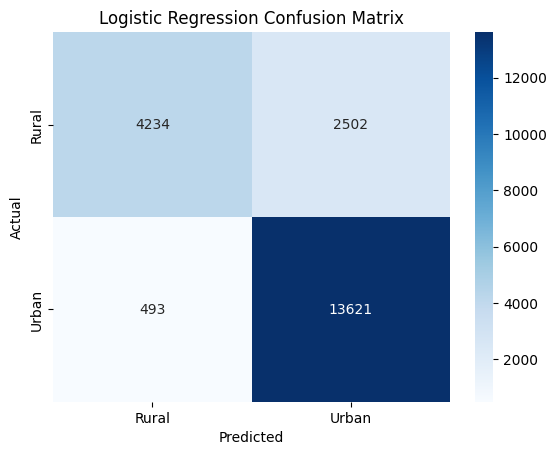

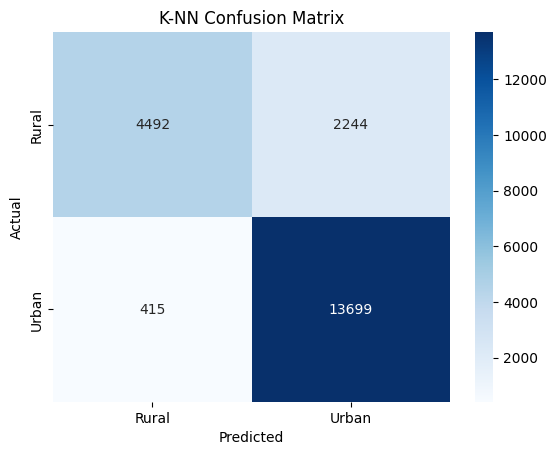

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['Rural', 'Urban'], yticklabels=['Rural', 'Urban'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# K-NN confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['Rural', 'Urban'], yticklabels=['Rural', 'Urban'])
plt.title('K-NN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [53]:
description = road_data.describe(include='all')
print(description)
# Save to Excel file
description.to_excel('road_data_description.xlsx', index=True)

       accident_index  accident_year accident_reference  \
count          104258       104258.0             104258   
unique         104258            NaN             104258   
top     2023991462793            NaN          991462793   
freq                1            NaN                  1   
mean              NaN         2023.0                NaN   
min               NaN         2023.0                NaN   
25%               NaN         2023.0                NaN   
50%               NaN         2023.0                NaN   
75%               NaN         2023.0                NaN   
max               NaN         2023.0                NaN   
std               NaN            0.0                NaN   

        location_easting_osgr  location_northing_osgr      longitude  \
count           104258.000000            1.042580e+05  104258.000000   
unique                    NaN                     NaN            NaN   
top                       NaN                     NaN            NaN   
fre

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np


# Load dataset
car_data = pd.read_csv('bmw.csv')

# Convert categorical features to numeric using pd.get_dummies
car_data = pd.get_dummies(car_data, drop_first=True)

# Define features and target
X = car_data.drop('price', axis=1)  # features
y = car_data['price']  # target

# Split the data
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (Linear Regression requires scaling)
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

# Fit the model
model = LinearRegression()
model.fit(X2_train_scaled, y2_train)

# Predict and evaluate
y2_pred = model.predict(X2_test_scaled)

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
r2 = r2_score(y2_test, y2_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 4257.787842417903
R²: 0.8598093284080306


In [ ]:
description = car_data.describe()
print(description)
# Save to Excel file
description.to_excel('car_data_description.xlsx', index=True)


               year          price        mileage           tax           mpg  \
count  10781.000000   10781.000000   10781.000000  10781.000000  10781.000000   
mean    2017.078935   22733.408867   25496.986550    131.702068     56.399035   
std        2.349038   11415.528189   25143.192559     61.510755     31.336958   
min     1996.000000    1200.000000       1.000000      0.000000      5.500000   
25%     2016.000000   14950.000000    5529.000000    135.000000     45.600000   
50%     2017.000000   20462.000000   18347.000000    145.000000     53.300000   
75%     2019.000000   27940.000000   38206.000000    145.000000     62.800000   
max     2020.000000  123456.000000  214000.000000    580.000000    470.800000   

         engineSize  
count  10781.000000  
mean       2.167767  
std        0.552054  
min        0.000000  
25%        2.000000  
50%        2.000000  
75%        2.000000  
max        6.600000  


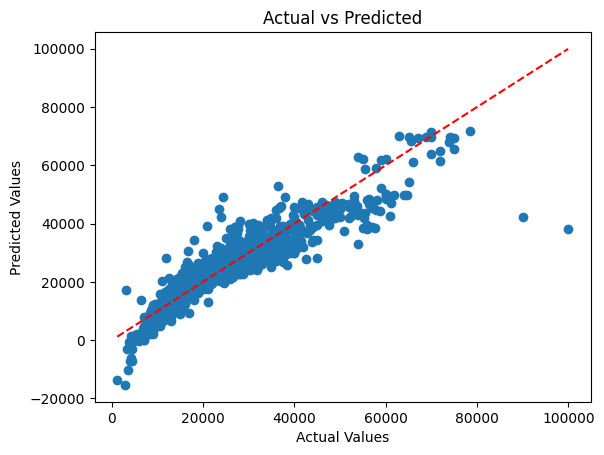

In [39]:
import matplotlib.pyplot as plt

# Scatter plot: Actual vs Predicted
plt.scatter(y2_test, y2_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')

# Add a red diagonal line (y = x)
plt.plot([min(y2_test), max(y2_test)], [min(y2_test), max(y2_test)], color='red', linestyle='--')

plt.show()
